In [13]:
import torch

torch.cuda.is_available()


True

In [14]:
import pandas as pd
df = pd.read_csv('../data/Union/Hyperion.csv')


In [15]:
import string

#Find bounds starting froma text
def find_char_bounds(spans: list, text: str) -> list:
    '''
    Given a list of spans and a text, find the start and end indices of each span in the text.
    Indeces are computed counting CHARS
    
    :param spans: a list of strings to search for
    :type spans: list
    :param text: the text to search
    :type text: str
    :return: A list of tuples, where each tuple contains the start and end index of a span.
    '''
    start = 0
    bounds = []
    last_char = -1
    for span in spans:
        start = text.find(span)
        if start == -1:
            start = last_char + 1
        last_char = start + len(span)
        bounds.append((start, last_char))
        
    return bounds


def find_word_bounds(spans: list, text: str) -> list:
    '''
    Given a list of spans and a text, find the start and end indices of each span in the text.
    Indeces are computed counting WORDS.

    :param spans: a list of strings, each string is a span of text
    :type spans: list
    :param text: the text to be searched
    :type text: str
    :return: A list of tuples, where each tuple is the start and end index of a word in the text.
    '''
    bounds = []
    end = 0
    for span in spans:
        s = span.translate(str.maketrans('', '', string.punctuation))
        word_list = s.split()
        if word_list:   
            text_list = text.translate(str.maketrans('', '', string.punctuation)).split()
            try:
                start = text_list.index(word_list[0], end)
            except:
                if not bounds:
                    start = 0
                else:

                    start = bounds[-1][1] + 1
            end = start + len(word_list) - 1

            bounds.append((start, end))
    return bounds

def find_segmentation(bounds, text):
    text_list = text.translate(str.maketrans('', '', string.punctuation)).split()
    segmentation = ['0' for i in range(len(text_list))]
    segmentation[-1] = '1'
    
    ends = []
    end = 0
    for span in spans:
        word_list = span.translate(str.maketrans('', '', string.punctuation)).split()
        try:
            end = text_list.index(word_list[-1], end)
        except:
                end = end + len(word_list) -1
        if end < len(text_list):
            ends.append(end)
    for i in ends:
        segmentation[i] = '1'
    
    return ''.join(segmentation)

def find_segmentation_by_bounds(bounds: list) -> str:
    segmentation = ['0' for i in range(bounds[-1][1] + 1)]
    for bound in bounds:
        if bound[1] < len(segmentation):
            segmentation[bound[1]] = '1'
    segmentation[-1] = '1'
    return ''.join(segmentation)

In [16]:
from transformers import AutoTokenizer
import re

def clean_text(text:str) -> str:
    #delete double punctuation
    text =  re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)
    # add space between a word and punctuation
    text = re.sub('(?<! )(?=[.,!?()])|(?<=[.,!?()])(?! )', r' ', text)
    return text

dataset = []

for row in df.itertuples():
    text = row.Testo
    
    if pd.isna(text):
        sample['Stralci'].append(clean_text(row.Stralcio))
        sample['Repertori'].append(row.Repertorio)

    else:
        sample = {}
        sample['Testo'] = clean_text(text)
        sample['Stralci'] = [clean_text(row.Stralcio)]

        sample['Repertori'] = [row.Repertorio]
        dataset.append(sample)


for sample in dataset:
    sample['Char_Bounds'] = find_char_bounds(sample['Stralci'], sample['Testo'])
    sample['Bounds'] = find_word_bounds(sample['Stralci'], sample['Testo'])
    sample['Char_Segmentation'] = find_segmentation_by_bounds(sample['Char_Bounds'])
    sample['Segmentation'] = find_segmentation_by_bounds(sample['Bounds'])


In [17]:
IE_dict = {
    'Testo': [sample['Testo'] for sample in dataset],
    'Char_Segmentation': [sample['Char_Segmentation'] for sample in dataset],
    'Segmentation': [sample['Segmentation'] for sample in dataset],
    'Bounds': [sample['Bounds'] for sample in dataset],
    'Char_Bounds': [sample['Char_Bounds'] for sample in dataset],
    'Repertori': [sample['Repertori'] for sample in dataset],
    'Stralci': [sample['Stralci'] for sample in dataset]
}
IE_df = pd.DataFrame(IE_dict)
#IE_df = IE_df.head(100)

In [18]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch

class IE_Hyperion_dataset(Dataset):
    def __init__(self, df, tokenizer_name):
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.df = df

    def __getitem__(self, idx):
        text = self.df['Testo'].iloc[idx]
        encoding = self.tokenizer(text,
                                  # is_pretokenized=True,
                                  return_special_tokens_mask=True,
                                  return_offsets_mapping=True,
                                  add_special_tokens=True,
                                  return_attention_mask=True,
                                  padding='max_length',
                                  truncation=True,
                                  )
        char_labels = list(self.df['Char_Segmentation'].iloc[idx])
        ends = [i for i in range(len(char_labels)) if char_labels[i] == '1']

        last_token_idx = max(index for index, item in enumerate(encoding['special_tokens_mask']) if item == 0)

        encoded_labels = np.ones(len(encoding['input_ids']), dtype=int) * -100
        x = ends.pop(0)
        for i,e in enumerate(encoding['offset_mapping']):
            if e[1] != 0:
                # overwrite label
                if x >= e[0] and x <= e[1]:# Doubt if insert < e[1] because of offset mapping composition
                    encoded_labels[i] = 1
                    if ends: 
                        x = ends.pop(0)
                    else:
                        x = -1
                else:
                    encoded_labels[i] = 0

        encoded_labels[last_token_idx] = 1


        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        return item

    def __len__(self):
        return len(self.df.index)


In [19]:
model_name = "dbmdz/bert-base-italian-xxl-uncased"
train_size = 0.8
train_df = IE_df.sample(frac=train_size, random_state=200)
test_df = IE_df.drop(train_df.index).reset_index(drop=True)
train_df = train_df.reset_index(drop=True)
val_size = 0.2
val_df = train_df.sample(frac=val_size, random_state=200)
train_df = train_df.drop(val_df.index).reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

print("FULL Dataset: {}".format(IE_df.shape))
print("TRAIN Dataset: {}".format(train_df.shape))
print("VALIDATION Dataset: {}".format(val_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

train_dataset = IE_Hyperion_dataset(train_df, model_name)
val_dataset = IE_Hyperion_dataset(val_df, model_name)
test_dataset = IE_Hyperion_dataset(test_df, model_name)


FULL Dataset: (100, 7)
TRAIN Dataset: (64, 7)
VALIDATION Dataset: (16, 7)
TEST Dataset: (20, 7)


In [20]:
test_dataset.df['Char_Segmentation'].iloc[4]

'0000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001'

In [21]:
for token, label in zip(test_dataset.tokenizer.convert_ids_to_tokens(test_dataset[10]["input_ids"]), test_dataset[10]["labels"]):
  print('{0:10}  {1}'.format(token, label))

[CLS]       -100
presidente  0
si          0
ritorni     0
ai          0
200         0
##m         1
la          0
gente       0
sta         0
facendo     0
quello      0
che         0
vuole       0
qui         0
a           0
mestre      0
.           0
tutto       0
quello      0
che         0
abbiamo     0
fatto       0
noi         0
sanitari    0
non         0
servirebbe  0
a           0
nulla       0
!           1
[SEP]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100

In [22]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(
    model_name, num_labels=2)


Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not in

In [23]:
import random
import os

import torch
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


# Deterministic mode
def seed_everything(seed=1464):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


def plot_loss(loss, val_loss):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(range(1, len(loss)+1))
    plt.plot(range(1, len(loss)+1), loss, label='train')
    plt.plot(range(1, len(val_loss)+1), val_loss, label='val')
    plt.title('loss')
    plt.legend()
    # plt.savefig('loss.png')
    return fig


def plot_f1(f1, val_f1):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(range(1, len(f1)+1))
    plt.plot(range(1, len(f1)+1), f1, label='train')
    plt.plot(range(1, len(val_f1)+1), val_f1, label='val')
    plt.title('f1')
    plt.legend()
    # plt.savefig('f1.png')
    return fig


def plot_confusion_matrix(y_true, pred, labels):
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, pred, display_labels=labels, normalize='true', values_format='.2f')
    disp.plot(cmap="Blues", values_format='.2g',
              xticks_rotation='vertical', ax=ax)
    return disp.figure_


In [24]:
import neptune.new as neptune


class NeptuneLogger():
    def __init__(self) -> None:
        # Neptune initialization
        self.run = neptune.init(
            project="mibo8/Rep",
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmZmRkYThiZi1mZGNlLTRlMTktODQwNS1hNWFlMWQ2Mjc4N2IifQ==",
        )


In [25]:
import time
import datetime
from torch.nn import utils

import torchmetrics
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import get_constant_schedule_with_warmup


import neptune.new as neptune


class IE_MPTrainer():
    def __init__(self, batch_size, lr, n_epochs) -> None:
        self.batch_size = batch_size
        self.learning_rate = lr
        self.n_epochs = n_epochs

        self.logger = NeptuneLogger()

    def fit(self, model, train_dataset, val_dataset):
        self.logger.run['model'] = model_name

        params_info = {
            'learning_rate': self.learning_rate,
            'batch_size': self.batch_size,
            'n_epochs': self.n_epochs
        }
        #self.logger.run['params'] = params_info

        torch.cuda.empty_cache()
        # ----------TRAINING

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        epochs_train_loss = []
        epochs_val_loss = []

        epochs = self.n_epochs

        # Creation of Pytorch DataLoaders with shuffle=True for the traing phase
        train_dataloader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True)
        validation_dataloader = DataLoader(
            val_dataset, batch_size=self.batch_size, shuffle=True)

        # Adam algorithm optimized for tranfor architectures
        optimizer = AdamW(model.parameters(), lr=self.learning_rate)
        #scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=300)

        # Scaler for mixed precision
        scaler = torch.cuda.amp.GradScaler()

        # Setup for training with gpu
        device = torch.device(
            'cuda') if torch.cuda.is_available() else torch.device('cpu')
        model.to(device)

        # For each epoch...
        for epoch_i in range(0, epochs):

            # ========================================
            #               Training
            # ========================================

            # Perform one full pass over the training set.

            print("")
            print(
                '======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode: Dropout layers are active
            model.train()

            # For each batch of training data...
            for step, batch in enumerate(train_dataloader):

                # Progress update every 40 batches.
                if step % 10 == 0 and not step == 0:
                    # Compute time in minutes.
                    elapsed = format_time(time.time() - t0)

                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(
                        step, len(train_dataloader), elapsed))

                # Unpack this training batch from the dataloader.
                #
                #  copy each tensor to the GPU using the 'to()' method
                #
                # 'batch' contains three pytorch tensors:
                #   [0]: input ids
                #   [1]: attention masks
                #   [2]: labels
                b_input_ids = batch['input_ids'].to(device)
                b_input_mask = batch['attention_mask'].to(device)
                b_labels = batch['labels'].to(device)

                # clear any previously calculated gradients before performing a
                # backward pass
                model.zero_grad()

                # Perform a forward pass in mixed precision
                with torch.cuda.amp.autocast():
                    outputs = model(b_input_ids,
                                    attention_mask=b_input_mask,
                                    labels=b_labels)

                    loss = outputs[0]
                    logits = outputs[1]

                # Move logits and labels to CPU
                logits = logits.detach().cpu()
                label_ids = b_labels.to('cpu')

                # Perform a backward pass to compute the gradients in MIXED precision
                scaler.scale(loss).backward()

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end.
                total_train_loss += loss.item()

                # Unscales the gradients of optimizer's assigned params in-place before the gradient clipping
                scaler.unscale_(optimizer)

                # Clip the norm of the gradients to 1.0.
                # This helps and prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient in MIXED precision
                scaler.step(optimizer)
                scaler.update()
                # scheduler.step()

            # Compute the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(train_dataloader)
            epochs_train_loss.append(avg_train_loss)

            # Measure how long this epoch took.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.3f}".format(avg_train_loss))
            print("  Training epoch took: {:}".format(training_time))

            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure performance on
            # the validation set.

            print("")
            print("Running Validation...")

            t0 = time.time()

            # Put the model in evaluation mode: the dropout layers behave differently
            model.eval()

            total_val_loss = 0

            # Evaluate data for one epoch
            for batch in validation_dataloader:

                # Unpack this training batch from our dataloader.
                #
                # copy each tensor to the GPU using the 'to()' method
                #
                # 'batch' contains three pytorch tensors:
                #   [0]: input ids
                #   [1]: attention masks
                #   [2]: labels
                b_input_ids = batch['input_ids'].to(device)
                b_input_mask = batch['attention_mask'].to(device)
                b_labels = batch['labels'].to(device)

                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for training.
                with torch.no_grad():

                    # Forward pass, calculate logits
                    # argmax(logits) = argmax(Softmax(logits))
                    outputs = model(b_input_ids,
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
                    loss = outputs[0]
                    logits = outputs[1]

                # Accumulate the validation loss.
                total_val_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu()
                label_ids = b_labels.to('cpu')

            print('VALIDATION: ')

            # Compute the average loss over all of the batches.
            avg_val_loss = total_val_loss / len(validation_dataloader)
            epochs_val_loss.append(avg_val_loss)

            # Measure how long the validation run took.
            validation_time = format_time(time.time() - t0)

            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

        loss_fig = plot_loss(epochs_train_loss, epochs_val_loss)

        self.logger.run["loss"].upload(neptune.types.File.as_image(loss_fig))
        print("")
        print("Training complete!")

        print("Total training took {:} (h:mm:ss)".format(
            format_time(time.time()-total_t0)))

    def test(self, model, test_dataset):
        # ========================================
        #               Test
        # ========================================
        test_dataloader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False)

        # Setup for testing with gpu
        device = torch.device(
            'cuda') if torch.cuda.is_available() else torch.device('cpu')

        print("")
        print("Running Test...")
        t0 = time.time()

        # Save prediction for confusion matrix
        preds = []

        model.eval()

        total_test_loss = 0

        # Evaluate data for one epoch
        for batch in test_dataloader:
            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)
            b_special_tokens_mask = batch['special_tokens_mask'].to(device)
            with torch.no_grad():

                # Forward pass, calculate logits
                # argmax(logits) = argmax(Softmax(logits))
                outputs = model(b_input_ids,
                                attention_mask=b_input_mask,
                                labels=b_labels)
                loss = outputs[0]
                logits = outputs[1]

            # Accumulate the test loss.
            total_test_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu()  # shape (batch_size, seq_len, num_labels
            full_probs = logits.softmax(dim=-1)

            for i, sample_prob in enumerate(full_probs):
                active_prob = []
                for j, e in enumerate(b_special_tokens_mask[i]):
                    if(e == 0):
                        active_prob.append(sample_prob[j].tolist())
                preds.append(active_prob)

        avg_test_loss = total_test_loss / len(test_dataloader)
        #self.logger.run['test/loss'] = avg_test_loss
        test_time = format_time(time.time() - t0)

        print("  Test Loss: {0:.2f}".format(avg_test_loss))
        print("  Test took: {:}".format(test_time))

        return preds


In [26]:
# Hyperparameters
learning_rate = 1e-5
batch_size = 18
n_epochs = 2
trainer = IE_MPTrainer(batch_size, learning_rate, n_epochs)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.944
  Training epoch took: 0:00:02

Running Validation...
VALIDATION: 
  Validation Loss: 0.78
  Validation took: 0:00:01

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.580
  Training epoch took: 0:00:02

Running Validation...
VALIDATION: 
  Validation Loss: 0.40
  Validation took: 0:00:01

Training complete!
Total training took 0:00:12 (h:mm:ss)


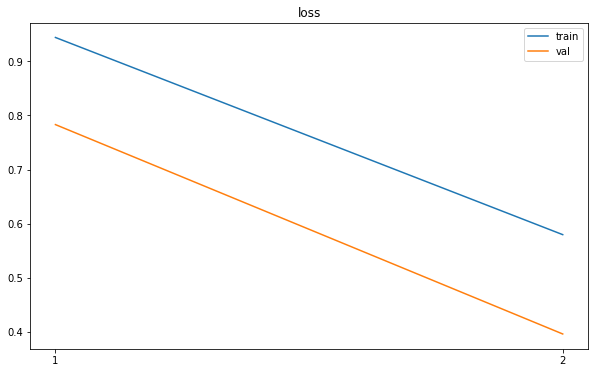

In [27]:
trainer.fit(model, train_dataset, val_dataset)


In [28]:
probs = trainer.test(model, test_dataset)


Running Test...
  Test Loss: 0.38
  Test took: 0:00:01


In [29]:
def decode_segmentation(probs, threshold):  #one sample
    if threshold < 0 or threshold > 1:
        return None
    segmentation = []
    for prob in probs:
        if prob[1] >= threshold:
            segmentation.append(1)
        else:
            segmentation.append(0)
    segmentation[-1] = 1
    return segmentation

def prediction_to_bounds(pred:list) -> list:
    bounds = []
    start = 0
    end = 0
    for i,e in enumerate(pred):
        if e == 0:
            end = i
            bounds.append((start, end))
            start = end + 1
    if not bounds:
        bounds.append((0, len(pred)))
    return bounds

# It discards the first -100 of the network output
def token_gt_bounds(pred:list) -> list:
    bounds = []
    start = 0
    end = 0
    for i,e in enumerate(pred[1:]):
        if e == 0:
            end = i
            bounds.append((start, end))
            start = end + 1
    if not bounds:
        bounds.append((0, len(pred)))
    return bounds

def split_by_prediction(pred:list, tok_ids:list, tokenizer) -> list:
    start = 0
    end = 0
    spans = []
    for i,e in enumerate(pred):
        if e == 1:
            end = i
            span = tokenizer.decode(tok_ids[start:end + 1], skip_special_tokens= True, clean_up_tokenization_spaces= False)
            spans.append(span)
            start = end + 1
            end = end + 1
    if not spans:
        spans.append(tokenizer.decode(tok_ids, skip_special_tokens= True, clean_up_tokenization_spaces= False))
    return spans

def split_by_prediction2(pred:list, input:dict, text:str, tokenizer) -> list:


    offset_mapping = input['offset_mapping'].tolist()
    i=0
    subword_flags = []
    while i < len(offset_mapping):
        if offset_mapping[i][1] != 0:
            if tokenizer.decode(input['input_ids'][i])[:2] == '##':
                subword_flags.append(True)
            else:
                subword_flags.append(False)
        i+=1
        
    for i in range(len(pred)-1):
        if pred[i] == 1:
            if subword_flags[i + 1]:
                pred[i] = 0
                pred[i + 1] =1
        
            
    spans = []
    start = 0
    i=0
    while i < len(offset_mapping):
        if offset_mapping[i][1] != 0:
            x = pred.pop(0)
            if x == 1:
                spans.append(text[start:offset_mapping[i][1]])
                start = offset_mapping[i][1]
        i+=1

    return spans

preds = [decode_segmentation(e, 0.3) for e in probs]

bert_preds = []
for i,e in enumerate(preds):
    spans = split_by_prediction2(e, test_dataset[i], test_dataset.df.iloc[i]['Testo'], test_dataset.tokenizer)
    bert_preds.append(find_word_bounds(spans, test_dataset.df.iloc[i]['Testo']))

In [30]:
import numpy as np
# A è B sono tupe con i bound dello span
def IoU(A, B):
    if A == B:
        return 1
    start = max(A[0], B[0])
    end = min(A[1], B[1])
    if(start > end):
        return 0
    intersection = end - start
    return intersection / (A[1] - A[0] + B[1] - B[0] - intersection)

def compute_IoUs(pred_bounds, gt_spans):
    """
    Given a list of predicted spans and a list of ground truth spans, 
    compute the IoU between each pair of spans
    
    :param pred_bounds: a tuple of (start, end) denoting the predicted answer
    :param gt_spans: a list of tuples of the form (start, end) representing the spans of each ground
    truth annotation
    :return: a list of IoUs for each ground truth span.
    """
    IoUs = []
    for gt_bounds in gt_spans:
        IoUs.append(IoU(pred_bounds, gt_bounds)) 
    return IoUs


def intersection(A, B):
    if A == B:
        return 1
    start = max(A[0], B[0])
    end = min(A[1], B[1])
    if(start > end):
        return 0
    return end - start

def normalize_bounds_by_repertoire(bounds, sample):
    bounds_w_rep = []
    for bound in bounds:
        intersections = []
        for gt_bound in sample['Bounds']:
            intersections.append(intersection(bound, gt_bound))
        rep_idx = np.argmax(intersections)
        bounds_w_rep.append({
            'Bounds': bound,
            'Repertorio': sample['Repertori'][rep_idx]
            })
    normalized = []
    for i in range(len(bounds_w_rep)):
        #normalized is not empty
        if normalized:
            if normalized[-1]['Repertorio'] == bounds_w_rep[i]['Repertorio']:
                new_span = (normalized[-1]['Bounds'][0], bounds_w_rep[i]['Bounds'][1])
                new_span_features = {
                    'Bounds' : new_span, 
                    'Repertorio' : bounds_w_rep[i]['Repertorio']
                    }
                del normalized[-1]
                normalized.append(new_span_features)
            else:
                normalized.append(bounds_w_rep[i])
        else:
            normalized.append(bounds_w_rep[i])
    return [e['Bounds'] for e in normalized]

In [33]:
from nltk.metrics.segmentation import windowdiff, ghd, pk

met_list = []


for i in range(len(test_dataset.df.index)):
    seg_pred = find_segmentation_by_bounds(bert_preds[i])
    seg_pred = seg_pred[:len(test_dataset.df['Segmentation'].iloc[i])]
    
    
    wd_value = windowdiff(test_dataset.df['Segmentation'].iloc[i], seg_pred,  6)
    
    ghd_value = ghd(test_dataset.df['Segmentation'].iloc[i], seg_pred)
    
    pk_value = pk(test_dataset.df['Segmentation'].iloc[i], seg_pred, 6)

    text_IoUs = []
    for bound in bert_preds[i]:
        IoUs = compute_IoUs(bound, test_dataset.df['Bounds'].iloc[i])
        best = np.argmax(IoUs)
        text_IoUs.append(IoUs[best])
    
    met_dict = {
        'windowdiff' : wd_value,
        'ghd' : ghd_value,
        'pk' : pk_value,
        'iou' : text_IoUs
        }
    met_list.append(met_dict)

In [34]:
norm_met_list = []
norm_span_counter = 0

for i in range(len(test_dataset.df.index)):
    norm_pred_bounds = normalize_bounds_by_repertoire(bert_preds[i], test_dataset.df.iloc[i])
    norm_span_counter += len(norm_pred_bounds)

    seg_pred = find_segmentation_by_bounds(norm_pred_bounds)
    seg_pred = seg_pred[:len(test_dataset.df['Segmentation'].iloc[i])] #artificioso, sarebbe meglio risolvere ed avere le strighe uguali
    
    wd_value = windowdiff(test_dataset.df['Segmentation'].iloc[i], seg_pred,  6)
    
    ghd_value = ghd(test_dataset.df['Segmentation'].iloc[i], seg_pred)
    
    pk_value = pk(test_dataset.df['Segmentation'].iloc[i], seg_pred, 6)

    text_IoUs = []
    for bound in norm_pred_bounds:
        IoUs = compute_IoUs(bound, test_dataset.df['Bounds'].iloc[i])
        best = np.argmax(IoUs)
        text_IoUs.append(IoUs[best])
    
    norm_met_dict = {
        'windowdiff' : wd_value,
        'ghd' : ghd_value,
        'pk' : pk_value,
        'iou' : text_IoUs
        }
    norm_met_list.append(norm_met_dict)

In [35]:
print('----------------------------------------------------------')
print('Risultati labels GT e stralci non uniti')

print('Numero testi nel dataset:', str(len(dataset)))

n_spans = 0
for e in dataset:
    n_spans += len(e['Bounds'])
print('Numero stralci nel dataset:', str(n_spans))

n_spans = 0
for e in bert_preds:
    n_spans += len(e)
print('Numero stralci predetti:', str(n_spans))

IoUs = [e['iou'] for e in met_list]
flat_IoUs = [item for sublist in IoUs for item in sublist]
mean_IoU = np.mean(flat_IoUs)
mean_wd = np.mean([e['windowdiff'] for e in met_list])
mean_pk = np.mean([e['pk'] for e in met_list])
mean_ghd = np.mean([e['ghd'] for e in met_list])

perfect_spans = flat_IoUs.count(1)
print('Percentuale span perfetti: ', str(perfect_spans / len(flat_IoUs)))

print('Media IoU:', str(mean_IoU))
print('Media Windowdiff:', str(mean_wd))
print('Media Pk:', str(mean_pk))
print('Media ghd:', str(mean_ghd))


----------------------------------------------------------
Risultati labels GT e stralci non uniti
Numero testi nel dataset: 15332
Numero stralci nel dataset: 35148
Numero stralci predetti: 487
Percentuale span perfetti:  0.004106776180698152
Media IoU: 0.04996379919031166
Media Windowdiff: 0.8982559971372058
Media Pk: 0.6056211724085222
Media ghd: 40.75


In [36]:
print('----------------------------------------------------------')
print('Risultati labels GT e stralci uniti')

print('Numero testi nel dataset:', str(len(dataset)))

n_spans = 0
for e in dataset:
    n_spans += len(e['Bounds'])
print('Numero stralci nel dataset:', str(n_spans))

print('Numero stralci predetti:', str(norm_span_counter))

IoUs = [e['iou'] for e in norm_met_list]
flat_IoUs = [item for sublist in IoUs for item in sublist]
mean_IoU = np.mean(flat_IoUs)
mean_wd = np.mean([e['windowdiff'] for e in norm_met_list])
mean_pk = np.mean([e['pk'] for e in norm_met_list])
mean_ghd = np.mean([e['ghd'] for e in norm_met_list])

perfect_spans = flat_IoUs.count(1)

print('Percentuale span perfetti: ', str(perfect_spans / len(flat_IoUs)))

print('Media IoU:', str(mean_IoU))
print('Media Windowdiff:', str(mean_wd))
print('Media Pk:', str(mean_pk))
print('Media ghd:', str(mean_ghd))


----------------------------------------------------------
Risultati labels GT e stralci uniti
Numero testi nel dataset: 15332
Numero stralci nel dataset: 35148
Numero stralci predetti: 115
Percentuale span perfetti:  0.06086956521739131
Media IoU: 0.32918700626641506
Media Windowdiff: 0.39976994931515464
Media Pk: 0.2990910478020403
Media ghd: 9.45
